In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
#from shapely.geometry import Point, MultiPoint, Polygon
#from pyproj import CRS
import pandana
#from pandana.loaders import osm

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

In [2]:
city = 'WAR'

if city == 'COP':
    cityname = 'Copenhagen, Denmark'
elif city == 'HEL':
    cityname = 'Helsinki, Finland'
elif city == 'WAR':
    cityname = 'Warsaw, Poland'

In [3]:
# Get graph from place (could also use bbox)
#graph = ox.graph.graph_from_bbox(60.1769, 60.1553, 24.9112, 24.9617, network_type='walk')
graph = ox.graph.graph_from_place(cityname, network_type='walk')

# Project
#graph = ox.projection.project_graph(graph, to_crs=3035)

In [4]:
# Plot (or save minutes by not plotting)
#fig, ax = ox.plot_graph(graph)

In [5]:
# Max time to walk
walk_time = 10

# Walking speed
walk_speed = 4.5

# set a uniform walking speed on every edge
for u, v, data in graph.edges(data=True):
    data['speed_kph'] = walk_speed
graph = ox.add_edge_travel_times(graph)

# extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

In [6]:
# Select pois based on osm tags
tags = {
    'amenity':[
        'cafe',
        'bar',
        'pub',
        'restaurant'
    ],
    'shop':[
        'bakery',
        'convenience',
        'supermarket',
        'mall',
        'department_store',
        'clothes',
        'fashion',
        'shoes'
    ],
    'leisure':[
        'fitness_centre'
    ]
}

# Get amentities from bbox
#amenities = ox.geometries.geometries_from_bbox(
#    60.1769, 60.1553, 24.9112, 24.9617,
#    tags=tags
#)

# Get amentities from place
amenities = ox.geometries.geometries_from_place(
    cityname,
    tags=tags
)

# Point version for gpkg
amenities_point = amenities[amenities['geometry'].apply(lambda x: x.type=='Point')]

In [8]:
# Save as gpkg
amenities_point.to_file('amenities_'+city+'.gpkg', driver='GPKG')

In [9]:
# construct the pandana network model
network = pandana.Network(
    node_x=nodes['x'],
    node_y=nodes['y'], 
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)


# extract approximate, unprojected centroids from the amenities' geometries
centroids = amenities.centroid

<ipython-input-9-82ad821a4219>:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = amenities.centroid


In [10]:
# Specify a max travel distance for analysis
# Minutes -> seconds, to match travel_time units
maxdist = walk_time * 60

# Set the amenities' locations on the network
network.set_pois(
    category='pöhinä',
    maxdist=maxdist,
    maxitems=10,
    x_col=centroids.x, 
    y_col=centroids.y
)

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [11]:
# calculate travel time to nearest amenity from each node in network
distances = network.nearest_pois(
    distance=maxdist,
    category='pöhinä',
    num_pois=10
)

distances.astype(int).head()

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
26063726,289,372,495,503,537,579,600,600,600,600
26063729,219,353,564,573,600,600,600,600,600,600
26063848,386,438,443,504,600,600,600,600,600,600
26063856,244,289,423,463,470,474,474,516,600,600
26063857,214,320,432,440,444,444,453,485,600,600


/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


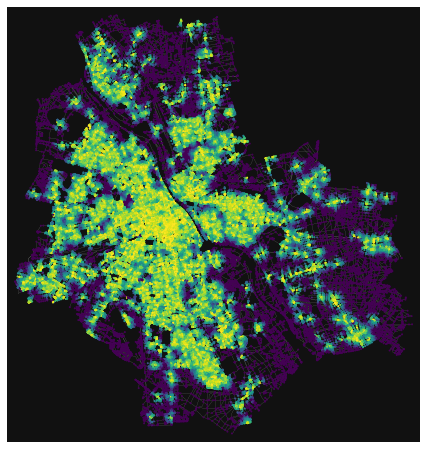

In [12]:
# plot distance to nearest amenity
fig, ax = ox.plot_graph(
    graph,
    node_size=0,
    edge_linewidth=0.1,
    edge_color='gray',
    show=False,
    close=False
)

sc = ax.scatter(
    x=nodes['x'],
    y=nodes['y'], 
    c=distances[1],
    s=1,
    cmap='viridis_r'
)

#ax.set_title(f'Walking time to nearest poi')
#plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

In [13]:
distances

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
26063726,289.600006,372.299988,495.799988,503.399994,537.000000,579.400024,600.000000,600.000000,600.000000,600.000000
26063729,219.500000,353.399994,564.999023,573.900024,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
26063848,386.200012,438.500000,443.700012,504.799988,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
26063856,244.399994,289.898987,423.498993,463.100006,470.700012,474.899994,474.899994,516.200012,600.000000,600.000000
26063857,214.000000,320.299011,432.700012,440.299988,444.500000,444.500000,453.898987,485.799988,600.000000,600.000000
...,...,...,...,...,...,...,...,...,...,...
8851361460,260.600006,302.899994,341.799988,342.899994,408.500000,432.200012,432.299988,457.799988,475.600006,507.799988
8851361461,238.100006,280.399994,319.299988,320.399994,386.000000,409.700012,409.799988,435.299988,453.100006,485.299988
8851469862,245.699997,282.000000,310.200012,375.899994,384.500000,495.000000,578.900024,600.000000,600.000000,600.000000


In [14]:
nodes

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,x,y
osmid,,
26063726,21.017454,52.152787
26063729,21.017666,52.142444
26063848,20.991392,52.157570
26063856,20.992216,52.166076
26063857,20.992301,52.166411
...,...,...
8851361460,20.999352,52.210353
8851361461,20.998940,52.210336
8851469862,20.959805,52.187819


In [15]:
walk_access = nodes.join(distances, on='osmid', how='left')

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
type(walk_access)

pandas.core.frame.DataFrame

In [17]:
walk_access.to_csv('walk_access_'+city+'.csv', encoding='utf-8')
